# 한정된 데이터로 Transfer learning 적용해보기 

## 1. CT이미지 데이터셋 살펴보기

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_dir = "../DATASET/Segmentation/"
data_df = pd.read_csv(os.path.join(data_dir, "train.csv"))
data_df.head()

,ImageId,MaskId
0,ID00007637202177411956430_0.jpg,ID00007637202177411956430_mask_0.jpg
1,ID00007637202177411956430_1.jpg,ID00007637202177411956430_mask_1.jpg
2,ID00007637202177411956430_2.jpg,ID00007637202177411956430_mask_2.jpg
3,ID00007637202177411956430_3.jpg,ID00007637202177411956430_mask_3.jpg
4,ID00007637202177411956430_4.jpg,ID00007637202177411956430_mask_4.jpg


In [3]:
def extract_client_id(x):
    return x.split("_")[0]

In [4]:
data_df["Id"] = data_df.ImageId.apply(lambda x:extract_client_id(x))
data_df

,ImageId,MaskId,Id
0,ID00007637202177411956430_0.jpg,ID00007637202177411956430_mask_0.jpg,ID00007637202177411956430
1,ID00007637202177411956430_1.jpg,ID00007637202177411956430_mask_1.jpg,ID00007637202177411956430
2,ID00007637202177411956430_2.jpg,ID00007637202177411956430_mask_2.jpg,ID00007637202177411956430
3,ID00007637202177411956430_3.jpg,ID00007637202177411956430_mask_3.jpg,ID00007637202177411956430
4,ID00007637202177411956430_4.jpg,ID00007637202177411956430_mask_4.jpg,ID00007637202177411956430
...,...,...,...
16703,ID00426637202313170790466_403.jpg,ID00426637202313170790466_mask_403.jpg,ID00426637202313170790466
16704,ID00426637202313170790466_404.jpg,ID00426637202313170790466_mask_404.jpg,ID00426637202313170790466
16705,ID00426637202313170790466_405.jpg,ID00426637202313170790466_mask_405.jpg,ID00426637202313170790466
16706,ID00426637202313170790466_406.jpg,ID00426637202313170790466_mask_406.jpg,ID00426637202313170790466


In [5]:
def get_client_data(data_df, index):
    client_ids = np.unique(data_df.Id.values)
    client_id = client_ids[index]
    client_data = data_df[data_df.Id == client_id]
    image_files = list(client_data["ImageId"])
    mask_files = list(client_data["MaskId"])
    return client_id, image_files, mask_files

In [6]:
regions = ["background", "trachea", "heart", "lung"]
colors = ((0,0,0), (255, 0, 0), (0, 255, 0), (0, 0, 255))

In [7]:
index = 50
client_id, image_files, mask_files = get_client_data(data_df, index)

canvas = np.zeros(shape=(512, 2*512+50, 3), dtype=np.uint8)
for i in range(len(image_files)):
    image = cv2.imread(os.path.join(data_dir, "images", image_files[i]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(os.path.join(data_dir, "masks", mask_files[i]))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    thres = 240
    mask[mask < thres] = 0
    mask[mask >= thres] = 255
    
    canvas[:, :512, :] = image
    canvas[:, 512+50:2*512+50, :] = mask
    
    text_buff = 410
    for j in range(1, len(regions)):
        cv2.putText(canvas, f'{regions[j].upper()}', (900, text_buff), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, colors[j], 2)
        text_buff += 40
    
    cv2.imshow('image', canvas)
    key = cv2.waitKey(60)
    if key == 27:
        break
    if key == ord('s'):
        cv2.waitKey(0)
cv2.destroyAllWindows()

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1272: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


## 2. 데이터셋 구축과 연산을 위한 텐서변환 모듈 작성하기

In [22]:
import torch

IMAGE_SIZE = 224

In [23]:
class CT_dataset():
    def __init__(self, data_dir, phase, transformer=None):
        self.phase = phase
        self.images_dir = os.path.join(data_dir, phase, "images")
        self.masks_dir = os.path.join(data_dir, phase, "masks")
        self.image_files = [filename for filename in os.listdir(self.images_dir) if filename.endswith("jpg")]
        self.mask_files =  [filename for filename in os.listdir(self.masks_dir) if filename.endswith("jpg")]
        assert len(self.image_files) == len(self.mask_files)
        
        self.transformer = transformer
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, index):
        image = cv2.imread(os.path.join(self.images_dir, self.image_files[index]))
        image = cv2.resize(image, dsize=(IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_LINEAR)
        mask = cv2.imread(os.path.join(self.masks_dir, self.mask_files[index]))
        mask = cv2.resize(mask, dsize=(IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
        # mask는 인접한 픽셀을 binary하게 채우는 nearest(비선형) 방식으로 해야함
        
        mask[mask < 240] = 0
        mask[mask >= 240] = 255
        # 손실압축 jpg형식 보안 
        mask = mask / 255.
        #normalize

        mask_H, mask_W, mask_C = mask.shape
        background = np.ones(shape=(mask_H, mask_W))
        background[mask[..., 0] != 0] = 0 #trachea
        background[mask[..., 1] != 0] = 0 #heart
        background[mask[..., 2] != 0] = 0 #lung셋 어느부분에도 속해있지 않으면 background
        #pixel 단위로 classification 되므로 background 영역 만듦 
        mask = np.concatenate([np.expand_dims(background, axis=-1), mask], axis=-1)
        #기존에 있던 mask dataset에 마지막 축 = Channel에 concatenate
        # np.expand_dims(background, axis=-1) = background.shape(H,W) -> (H,W,1)
        # 기존 mask.shape (H,W,C(3)) -> new mask.shape (H,W,C+1(4))
        mask = np.argmax(mask, axis=-1, keepdims=False)
        #4개 channel중 가장 높은 수치를 인덱스 값으로 나타냄
        # new mask.shape (H,W,4) -> new mask.shape (H,W)
        
        if self.transformer:
            image = self.transformer(image) #image dataset을 tensor형으로 변환하고 normalize
        
        target = torch.from_numpy(mask).long() #classification을 pixel 단위로 수행 -> integer형태로 변환
        return image, target

In [24]:
data_dir = "../DATASET/Segmentation/"
dset = CT_dataset(data_dir, "train")

In [25]:
dset[0]

(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 

In [26]:
from torchvision import transforms

def build_transformer():
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229, 0.224, 0.225])
    ])
    return transformer

In [27]:
transformer = build_transformer()
dset = CT_dataset(data_dir=data_dir, phase="train", transformer=transformer)

In [28]:
dset[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [29]:
image, target = dset[0]
print(f"image shape: {image.shape}")
print(f"target shape: {target.shape}")

image shape: torch.Size([3, 224, 224])
target shape: torch.Size([224, 224])


In [30]:
# dataloader에서 data를 반복적으로 불러오기 위해
def collate_fn(batch):
    images = []
    targets = []
    for a, b in batch:
        images.append(a)
        targets.append(b)
    images = torch.stack(images, dim=0)
    targets = torch.stack(targets, dim=0)
    return images, targets

In [31]:
from torch.utils.data import DataLoader

In [32]:
dloader = DataLoader(dset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [33]:
for index, batch in enumerate(dloader):
    images = batch[0]
    targets = batch[1]
    print(f"images shape: {images.shape}")
    print(f"targets shape: {targets.shape}")
    
    if index == 0:
        break

images shape: torch.Size([4, 3, 224, 224])
targets shape: torch.Size([4, 224, 224])


In [34]:
#train, val dataloder로 build하는 함수
def build_dataloader(data_dir, batch_size=4):
    transformer = build_transformer()
    
    dataloaders = {}
    train_dataset = CT_dataset(data_dir=data_dir, phase="train", transformer=transformer)
    dataloaders["train"] = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    # shuffle = False - transfer learning 을 위해 고정 120장만 사용하기 위해
    
    val_dataset = CT_dataset(data_dir=data_dir, phase="val", transformer=transformer)
    dataloaders["val"] = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    return dataloaders

In [35]:
data_dir = "../DATASET/Segmentation/"
dataloaders = build_dataloader(data_dir=data_dir)

for phase in ["train", "val"]:
    for index, batch in enumerate(dataloaders[phase]):
        images = batch[0]
        targets = batch[1]
        print(f"images shape: {images.shape}")
        print(f"targets shape: {targets.shape}")
        
        if index == 0:
            break

images shape: torch.Size([4, 3, 224, 224])
targets shape: torch.Size([4, 224, 224])
images shape: torch.Size([4, 3, 224, 224])
targets shape: torch.Size([4, 224, 224])


## 3. VGG16 Backbone 을 이용한 U-Net 아키텍처 구현해보기

In [36]:
def ConvLayer(in_channels, out_channels, kernel_size=3, padding=1):
    # kernel_size=3, padding=1 -> defalut로 준 이유 ->convolution연산에서 resolution loss 없게하려고
    layers = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        #UNet은 convolution연산을 기본적으로 2번씩 수행
    )
    return layers

def UpConvLayer(in_channels, out_channels):
    layers = nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
    return layers

In [37]:
import torch.nn as nn
from torchvision import transforms, models

In [38]:
vgg16 = models.vgg16_bn(pretrained = False)
vgg16

# UNet encoder channel =1024 / vgg16_bn의 layer는 512가 끝으로 512 convolution layer
#가져온 후 1024 feature map으로 변환하는 convolution layer 하나 추가해야함

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [39]:
class Encoder(nn.Module):
    def __init__(self, pretrained):
        super().__init__()
        backbone = models.vgg16_bn(pretrained=pretrained).features
        self.conv_block1 = nn.Sequential(*backbone[:6])
        self.conv_block2 = nn.Sequential(*backbone[6:13])
        self.conv_block3 = nn.Sequential(*backbone[13:20])
        self.conv_block4 = nn.Sequential(*backbone[20:27])
        self.conv_block5 = nn.Sequential(*backbone[27:34], 
                                         ConvLayer(512, 1024, kernel_size=1, padding=0))
        #채널변화만 주기위해 kernel_size =1 / 커널사이즈가 1이니깐 padding = 0
    def forward(self, x):
        encode_features = []
        out = self.conv_block1(x)
        encode_features.append(out)
        
        out = self.conv_block2(out)
        encode_features.append(out)
        
        out = self.conv_block3(out)
        encode_features.append(out)
        
        out = self.conv_block4(out)
        encode_features.append(out)
        
        out = self.conv_block5(out)
        return out, encode_features

In [40]:
encoder = Encoder(pretrained=False)
x = torch.randn(1, 3, 224, 224)
out, ftrs = encoder(x)

In [41]:
for ftr in ftrs:
    print(ftr.shape)
print(out.shape)

torch.Size([1, 64, 224, 224])
torch.Size([1, 128, 112, 112])
torch.Size([1, 256, 56, 56])
torch.Size([1, 512, 28, 28])
torch.Size([1, 1024, 14, 14])


In [42]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.upconv_layer1 = UpConvLayer(in_channels=1024, out_channels=512)
        self.conv_block1 = ConvLayer(in_channels=512+512, out_channels=512)
        # skip connection 과 concat 되므로 512 +512
        
        self.upconv_layer2 = UpConvLayer(in_channels=512, out_channels=256)
        self.conv_block2 = ConvLayer(in_channels=256+256, out_channels=256)
        
        self.upconv_layer3 = UpConvLayer(in_channels=256, out_channels=128)
        self.conv_block3 = ConvLayer(in_channels=128+128, out_channels=128)
        
        self.upconv_layer4 = UpConvLayer(in_channels=128, out_channels=64)
        self.conv_block4 = ConvLayer(in_channels=64+64, out_channels=64)
        
    def forward(self, x, encoder_features):
        out = self.upconv_layer1(x)
        out = torch.cat([out, encoder_features[-1]], dim=1)
        out = self.conv_block1(out)
        
        out = self.upconv_layer2(out)
        out = torch.cat([out, encoder_features[-2]], dim=1)
        out = self.conv_block2(out)
        
        out = self.upconv_layer3(out)
        out = torch.cat([out, encoder_features[-3]], dim=1)
        out = self.conv_block3(out)
        
        out = self.upconv_layer4(out)
        out = torch.cat([out, encoder_features[-4]], dim=1)
        out = self.conv_block4(out)
        return out

In [43]:
encoder = Encoder(pretrained=False)
decoder = Decoder()
x = torch.randn(1, 3, 224, 224)
out, ftrs = encoder(x)
out = decoder(out, ftrs)

In [44]:
print(out.shape)

torch.Size([1, 64, 224, 224])


In [45]:
class UNet(nn.Module):
    def __init__(self, num_classes, pretrained):
        super().__init__()
        self.encoder = Encoder(pretrained)
        self.decoder = Decoder()
        self.head = nn.Conv2d(64, num_classes, kernel_size=1)
        # input channel = 64 / output channel = num_classes(클래스개수)/
        # pointwise로 연산하기 위해 kernel_size = 1 , padding = 0
        
    def forward(self, x):
        out, encode_features = self.encoder(x)
        out = self.decoder(out, encode_features)
        out = self.head(out)
        return out

In [46]:
model = UNet(num_classes=4, pretrained=False)
x = torch.randn(1, 3, 224, 224)
out = model(x)

In [47]:
print(out.shape)

torch.Size([1, 4, 224, 224])


## 4. Semantic segmentation Loss와 학습코드 작성하기

In [48]:
import torch.nn.functional as F

In [49]:
#dice coefficient 지표는 semantic segmentation 에서 자주 사용
#validation 성능 측정 위해 UNet_metric 클래스 안에 dice coefficient 지표와 loss / CE 활용
class UNet_metric():
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.CE_loss = nn.CrossEntropyLoss(reduction="mean")
        
    def __call__(self, pred, target):
        loss1 = self.CE_loss(pred, target)
        #dice coefficient loss 구하기 위해 먼저 onehot vector로 pred , target 값 encoding
        onehot_pred = F.one_hot(torch.argmax(pred, dim=1), num_classes=self.num_classes).permute(0, 3, 1, 2)
        #target값은 class Id 값으로 component가 저장 -> argmax 함수 x
        onehot_target = F.one_hot(target, num_classes=self.num_classes).permute(0, 3, 1, 2)
        loss2 = self._get_dice_loss(onehot_pred, onehot_target)
        loss = loss1 + loss2
        
        dice_coefficient = self._get_batch_dice_coefficient(onehot_pred, onehot_target)
        return loss, dice_coefficient
    
    # onehot encoding 된 값이 batch로 들어오면 batch 크기 만큼 for문 돌려 
    # 각 batch index에 해당하는 pred / target 값의 onehot encoding된 metric을 하나씩 가져옴
    # dice coefficient를 계산해서 더한다.
    
    def _get_batch_dice_coefficient(self, pred, target):
        num_batch = pred.shape[0]
        dice = 0
        for batch_index in range(num_batch):
            dice += self._get_multiclass_dice_coefficient(pred[batch_index], target[batch_index])
        return dice / num_batch
    
    # binary = 클래스 1개일때
    def _get_dice_coeffient(self, pred, target):
        set_inter = torch.dot(pred.reshape(-1).float(), target.reshape(-1).float())#교집합
        set_sum = pred.sum() + target.sum()
        if set_sum.item() == 0:
            set_sum = 2 * set_inter #분모와 분자의 값이 1이 되게 해서 학습할게 없게 만듦
        dice_coeff = (2 * set_inter) / (set_sum + 1e-9) # + 1e-9 : 0으로 나눠지는거 방지
        return dice_coeff
    
    # 클래스 여러개 일때
    def _get_multiclass_dice_coefficient(self, pred, target):
        dice = 0
        for class_index in range(1, self.num_classes):#0은 background여서 1부터 for문
            dice += self._get_dice_coeffient(pred[class_index], target[class_index])
        return dice / (self.num_classes - 1)
    
    # batch에 들어있는 하나의 데이터는 4가지 멀티클래스의 pred, target값인데 target값의 
    # dice coefficient를 구하기 위해 get_multiclass_dice_coefficient 에서 class_index마다 
    # for문을 돌면서 binary 형태로 만들어주고 _get_dice_coeffient를 구한다.
    
    def _get_dice_loss(self, pred, target):
        return 1 - self._get_batch_dice_coefficient(pred, target)

In [50]:
data_dir = "../DATASET/Segmentation/"
dataloaders = build_dataloader(data_dir=data_dir)

for index, batch in enumerate(dataloaders["train"]):
    images = batch[0]
    targets = batch[1]
    predictions = model(images)
    
    if index == 0:
        break

In [51]:
criterion = UNet_metric(num_classes=4)

In [52]:
criterion(predictions, targets) #dice coefficient + CE 값 / dice 계수

(tensor(2.2932, grad_fn=<AddBackward0>), tensor(0.0221))

In [32]:
#학습
def train_one_epoch(dataloaders, model, criterion, optimizer, device):
    # loss를 구할 criterion, loss로 기울기 갱신 optimizer 
    losses = {}
    dice_coefficients = {}
    
    for phase in ["train", "val"]:
        running_loss = 0.0
        running_dice_coeff = 0.0
        
        if phase == "train":
            model.train()
        else:
            model.eval()
        
        for index, batch in enumerate(dataloaders[phase]):
            images = batch[0].to(device)
            targets = batch[1].to(device)
            
            with torch.set_grad_enabled(phase == "train"):
                predictions = model(images)
                loss, dice_coefficient = criterion(predictions, targets)
                
            if phase == "train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            running_loss += loss.item()
            running_dice_coeff += dice_coefficient.item()

            if index == 10: # 10 index * mini_batch 데이터수 만큼 데이터를 한정
                break

        losses[phase] = running_loss / index
        dice_coefficients[phase] = running_dice_coeff / index
        
    return losses, dice_coefficients

## 5. Weight Initialization 과 Transfer learning 모델 비교하기

### 5-1. He initialization

In [ ]:
def He_initialization(module):
    if isinstance(module, torch.nn.Conv2d):
        torch.nn.init.kaiming_normal_(module.weight) # He initialization
    elif isinstance(module, torch.nn.BatchNorm2d):
        module.weight.data.fill_(1.0)

In [39]:
data_dir = "../DATASET/Segmentation/"
is_cuda = True

NUM_CLASSES = 4
IMAGE_SIZE = 224
BATCH_SIZE = 12
DEVICE = torch.device('cuda' if torch.cuda.is_available() and is_cuda else 'cpu')

dataloaders = build_dataloader(data_dir, batch_size=BATCH_SIZE)
model = UNet(num_classes=NUM_CLASSES, pretrained=False)
model.apply(weight_He_initialization)
model = model.to(DEVICE)
criterion = UNet_metric(num_classes=NUM_CLASSES)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [40]:
num_epochs = 30

train_loss_def, train_dice_coefficient_def = [], []
val_loss_def, val_dice_coefficient_def = [], []

for epoch in range(num_epochs):
    losses, dice_coefficients = train_one_epoch(dataloaders, model, criterion, optimizer, DEVICE)
    train_loss_def.append(losses["train"])
    val_loss_def.append(losses["val"])
    train_dice_coefficient_def.append(dice_coefficients["train"])
    val_dice_coefficient_def.append(dice_coefficients["val"])
    
    print(f"{epoch}/{num_epochs} - Train loss: {losses['train']:.4f}, Val loss: {losses['val']:.4f}," + \
          f" Train dice: {dice_coefficients['train']:.4f}, Val dice: {dice_coefficients['val']:.4f}")

0/30 - Train loss: 2.6626, Val loss: 2.1546, Train dice: 0.0602, Val dice: 0.0487
1/30 - Train loss: 2.2176, Val loss: 1.8182, Train dice: 0.0827, Val dice: 0.0539
2/30 - Train loss: 1.8437, Val loss: 1.6423, Train dice: 0.1071, Val dice: 0.0701
3/30 - Train loss: 1.6344, Val loss: 1.5569, Train dice: 0.1181, Val dice: 0.0787
4/30 - Train loss: 1.5175, Val loss: 1.5088, Train dice: 0.1282, Val dice: 0.0859
5/30 - Train loss: 1.4379, Val loss: 1.4718, Train dice: 0.1430, Val dice: 0.0956
6/30 - Train loss: 1.3755, Val loss: 1.4369, Train dice: 0.1600, Val dice: 0.1087
7/30 - Train loss: 1.3221, Val loss: 1.4040, Train dice: 0.1777, Val dice: 0.1227
8/30 - Train loss: 1.2756, Val loss: 1.3742, Train dice: 0.1941, Val dice: 0.1362
9/30 - Train loss: 1.2354, Val loss: 1.3455, Train dice: 0.2081, Val dice: 0.1501
10/30 - Train loss: 1.2003, Val loss: 1.3193, Train dice: 0.2198, Val dice: 0.1629
11/30 - Train loss: 1.1700, Val loss: 1.2967, Train dice: 0.2293, Val dice: 0.1736
12/30 - Train 

### 5-2. Weight transfer pre-trained on ImageNet

In [41]:
data_dir = "../DATASET/Segmentation/"
is_cuda = True

NUM_CLASSES = 4
IMAGE_SIZE = 224
BATCH_SIZE = 12
DEVICE = torch.device('cuda' if torch.cuda.is_available() and is_cuda else 'cpu')

dataloaders = build_dataloader(data_dir, batch_size=BATCH_SIZE)
model = UNet(num_classes=NUM_CLASSES, pretrained=True)
model = model.to(DEVICE)
criterion = UNet_metric(num_classes=NUM_CLASSES)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [42]:
num_epochs = 30

train_loss_prt, train_dice_coefficient_prt = [], []
val_loss_prt, val_dice_coefficient_prt = [], []

for epoch in range(num_epochs):
    losses, dice_coefficients = train_one_epoch(dataloaders, model, criterion, optimizer, DEVICE)
    train_loss_prt.append(losses["train"])
    val_loss_prt.append(losses["val"])
    train_dice_coefficient_prt.append(dice_coefficients["train"])
    val_dice_coefficient_prt.append(dice_coefficients["val"])
    
    print(f"{epoch}/{num_epochs} - Train loss: {losses['train']:.4f}, Val loss: {losses['val']:.4f}," + \
          f" Train dice: {dice_coefficients['train']:.4f}, Val dice: {dice_coefficients['val']:.4f}")

0/30 - Train loss: 2.5675, Val loss: 2.5100, Train dice: 0.0862, Val dice: 0.0715
1/30 - Train loss: 2.2184, Val loss: 2.3311, Train dice: 0.0633, Val dice: 0.0004
2/30 - Train loss: 1.9612, Val loss: 2.0221, Train dice: 0.0091, Val dice: 0.0000
3/30 - Train loss: 1.8069, Val loss: 1.8172, Train dice: 0.0002, Val dice: 0.0000
4/30 - Train loss: 1.7273, Val loss: 1.7162, Train dice: 0.0000, Val dice: 0.0000
5/30 - Train loss: 1.6795, Val loss: 1.6654, Train dice: 0.0000, Val dice: 0.0000
6/30 - Train loss: 1.6404, Val loss: 1.6382, Train dice: 0.0000, Val dice: 0.0000
7/30 - Train loss: 1.5991, Val loss: 1.6143, Train dice: 0.0001, Val dice: 0.0000
8/30 - Train loss: 1.5501, Val loss: 1.5871, Train dice: 0.0011, Val dice: 0.0001
9/30 - Train loss: 1.4713, Val loss: 1.5324, Train dice: 0.0259, Val dice: 0.0046
10/30 - Train loss: 1.2950, Val loss: 1.4362, Train dice: 0.1491, Val dice: 0.0668
11/30 - Train loss: 1.1583, Val loss: 1.3052, Train dice: 0.2416, Val dice: 0.1700
12/30 - Train 

### 5-3. Weight transfer with freezing encoder layer

In [45]:
data_dir = "../DATASET/Segmentation/"
is_cuda = True

NUM_CLASSES = 4
IMAGE_SIZE = 224
BATCH_SIZE = 12
DEVICE = torch.device('cuda' if torch.cuda.is_available() and is_cuda else 'cpu')

dataloaders = build_dataloader(data_dir, batch_size=BATCH_SIZE)
model = UNet(num_classes=NUM_CLASSES, pretrained=True)
model = model.to(DEVICE)
model.encoder.requires_grad_ = False
criterion = UNet_metric(num_classes=NUM_CLASSES)
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9)

In [47]:
num_epochs = 30

train_loss_frz, train_dice_coefficient_frz = [], []
val_loss_frz, val_dice_coefficient_frz = [], []

for epoch in range(num_epochs):
    losses, dice_coefficients = train_one_epoch(dataloaders, model, criterion, optimizer, DEVICE)
    train_loss_frz.append(losses["train"])
    val_loss_frz.append(losses["val"])
    train_dice_coefficient_frz.append(dice_coefficients["train"])
    val_dice_coefficient_frz.append(dice_coefficients["val"])
    
    print(f"{epoch}/{num_epochs} - Train loss: {losses['train']:.4f}, Val loss: {losses['val']:.4f}," + \
          f" Train dice: {dice_coefficients['train']:.4f}, Val dice: {dice_coefficients['val']:.4f}")

0/30 - Train loss: 2.4897, Val loss: 2.5063, Train dice: 0.0813, Val dice: 0.0721
1/30 - Train loss: 2.1744, Val loss: 2.3675, Train dice: 0.0570, Val dice: 0.0240
2/30 - Train loss: 1.9315, Val loss: 2.1080, Train dice: 0.0097, Val dice: 0.0004
3/30 - Train loss: 1.7786, Val loss: 1.8504, Train dice: 0.0004, Val dice: 0.0000
4/30 - Train loss: 1.6900, Val loss: 1.7040, Train dice: 0.0001, Val dice: 0.0000
5/30 - Train loss: 1.6262, Val loss: 1.6337, Train dice: 0.0001, Val dice: 0.0000
6/30 - Train loss: 1.5659, Val loss: 1.6002, Train dice: 0.0011, Val dice: 0.0000
7/30 - Train loss: 1.4834, Val loss: 1.5592, Train dice: 0.0232, Val dice: 0.0004
8/30 - Train loss: 1.3156, Val loss: 1.5181, Train dice: 0.1378, Val dice: 0.0162
9/30 - Train loss: 1.1778, Val loss: 1.4137, Train dice: 0.2340, Val dice: 0.0918
10/30 - Train loss: 1.1039, Val loss: 1.3173, Train dice: 0.2705, Val dice: 0.1654
11/30 - Train loss: 1.0575, Val loss: 1.2599, Train dice: 0.2862, Val dice: 0.2039
12/30 - Train 

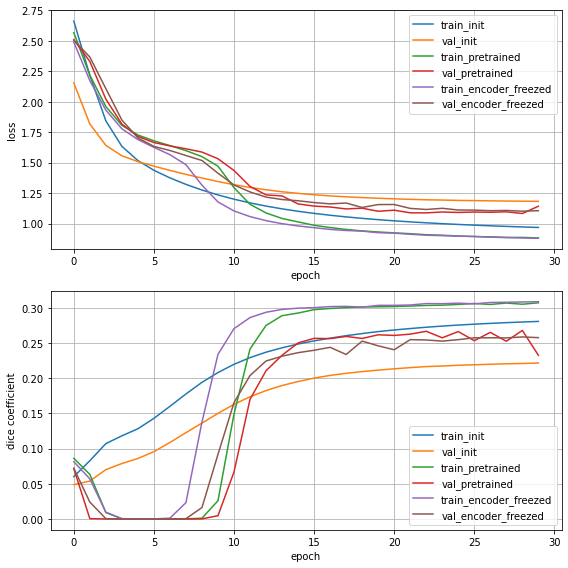